## Time Series Experiments

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.optimizers import RMSprop
%matplotlib inline

Using TensorFlow backend.


In [2]:
# We want to predict 360 units ahead
PRED_PERIODS = 360

In [3]:
# Data is number of TFL bike-hires daily
CSV_DATA = "https://iliadl.blob.core.windows.net/lstm/tfl_bike_data_daily.csv"

In [4]:
# Temporary: See what prediction is like with clean data
# Overwrite bike data with sin-wave
# Try setting this to False and re-running
use_sin_instead_of_messy_real_data = True

In [5]:
def plot_results(pred, truth):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    ax.plot(truth, label='Truth')
    plt.plot(pred, label='Predictions')
    plt.legend()
    plt.show()

In [6]:
# Daily data from 2012 to 2017
big_frame = pd.read_csv(CSV_DATA)
big_frame.index = big_frame.ds
print(big_frame.shape)
big_frame.head()

(1862, 2)


,ds,y
ds,,
2012-01-04 23:59:00,2012-01-04 23:59:00,13936
2012-01-05 23:59:00,2012-01-05 23:59:00,14191
2012-01-06 23:59:00,2012-01-06 23:59:00,17713
2012-01-07 23:59:00,2012-01-07 23:59:00,12556
2012-01-08 23:58:00,2012-01-08 23:58:00,10487


In [7]:
if use_sin_instead_of_messy_real_data:
    big_frame['y'] = np.sin(np.linspace(0, 300, len(big_frame)), dtype=np.float32)

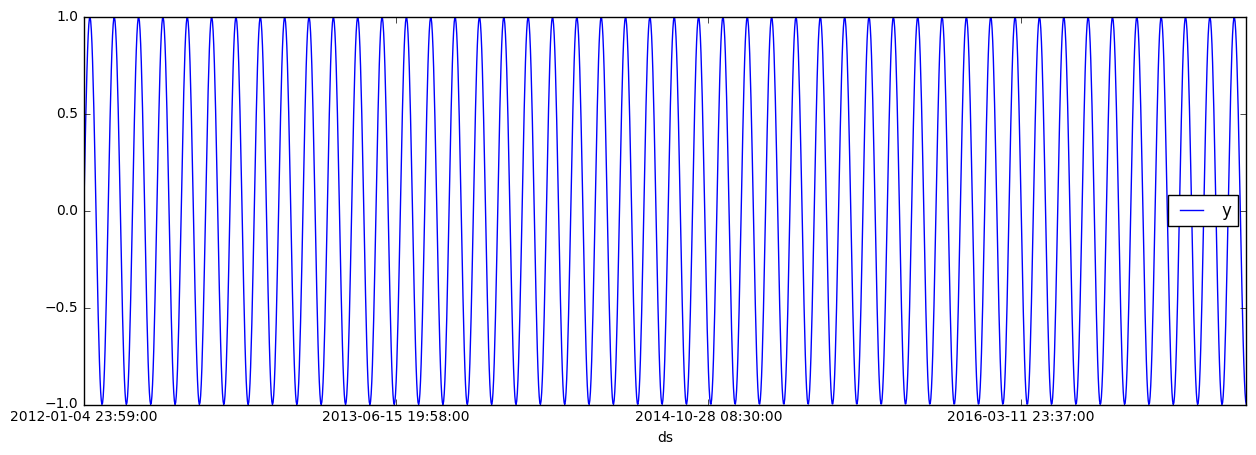

In [8]:
big_frame.plot(figsize=(15,5))

In [9]:
# Split into test and training
fb_train = big_frame[:len(big_frame)-PRED_PERIODS]
fb_test = big_frame[len(big_frame)-PRED_PERIODS:]

1502


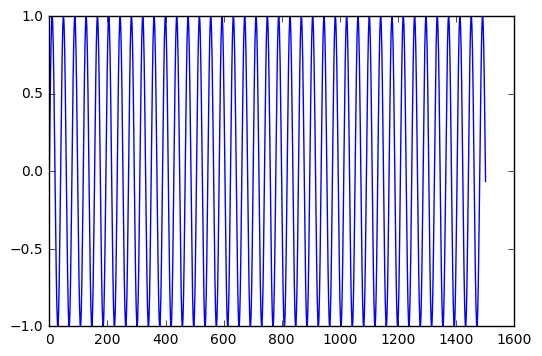

In [10]:
print(len(fb_train))
plt.plot(fb_train.y.values)

360


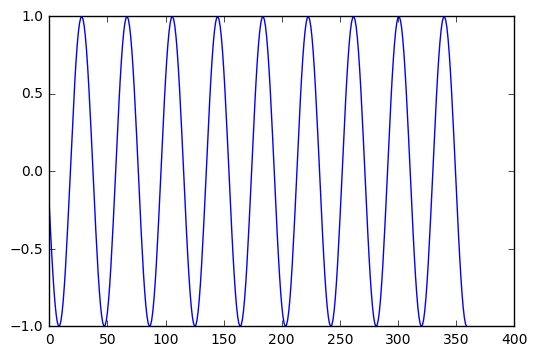

In [11]:
print(len(fb_test))
plt.plot(fb_test.y.values)

## Method 1 - Prophet

In [12]:
m = Prophet()
m.fit(fb_train)

In [13]:
future = m.make_future_dataframe(periods=PRED_PERIODS)
forecast = m.predict(future)

In [14]:
plot_guess = forecast[-PRED_PERIODS:]['yhat'].values
plot_truth = fb_test['y'].values

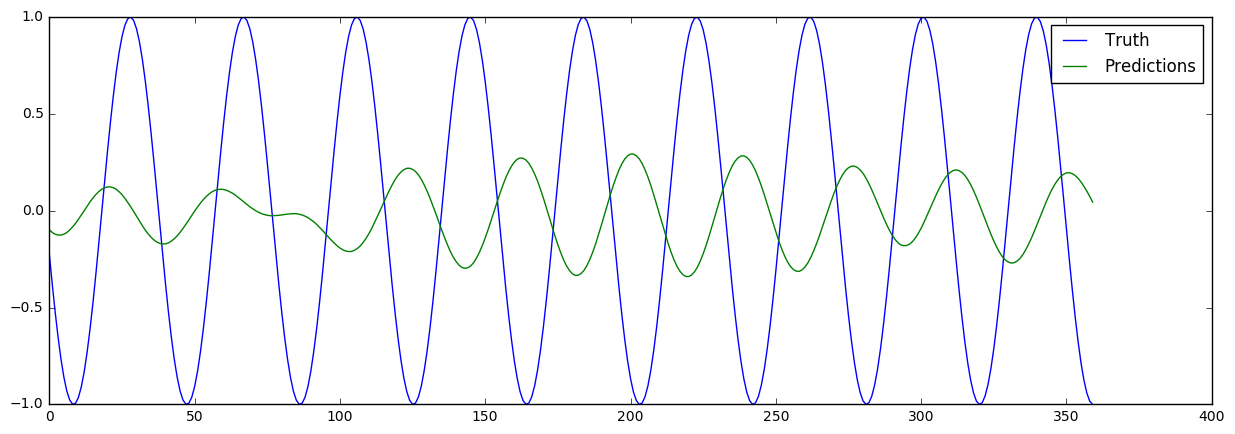

In [15]:
plot_results(plot_guess, plot_truth)

In [16]:
# Mean-Squared Error
sum((plot_guess-plot_truth)**2)/len(plot_guess)

0.66324937409620521

## Method 2 - LSTM (predict based on prev prediction; one-by-one)

1502


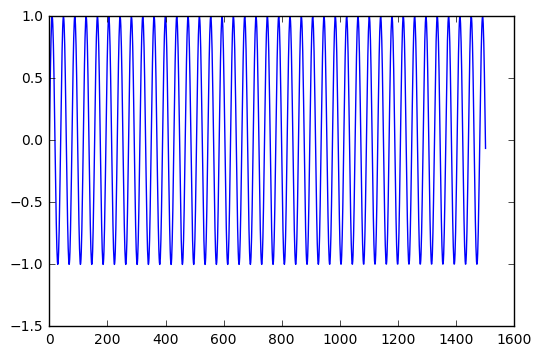

In [17]:
data = fb_train.y.values

# Scale to 0-1 range
scaled_by = max(data)
data = data/scaled_by

print(len(data))
plt.plot(data)

In [18]:
def load_data(data, seq_len):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    x_train = result[:, :-1]
    y_train = result[:, -1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return [x_train, y_train]

In [19]:
def build_model(layers):
    model = Sequential()
    
    model.add(LSTM(
        input_shape=(None, layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        units=layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=layers[-1]))
    model.add(Activation("linear"))

    start = time.time()
    optimizer = RMSprop()
    model.compile(loss='mse', optimizer=optimizer)
    print("> Compilation Time : ", time.time() - start)
    return model

1401


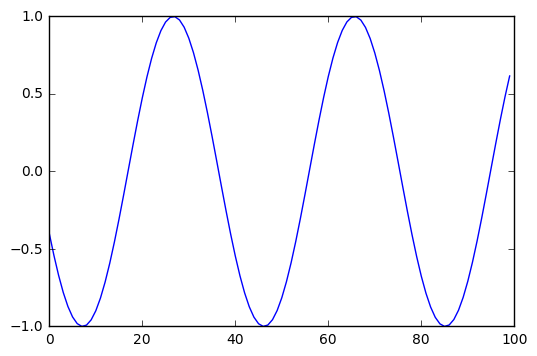

In [20]:
# Window-span
seq_len = 100
X_train, y_train = load_data(data, seq_len)
print(len(X_train))
plt.plot(y_train[:seq_len])

In [21]:
print(X_train.shape)
print(y_train.shape)

(1401, 100, 1)
(1401,)


In [22]:
model = build_model([1, 50, 100, 1])

model.fit(
    X_train,
    y_train,
    batch_size=400,
    epochs=3,
    validation_split=0.05)

> Compilation Time :  0.021195411682128906
Train on 1330 samples, validate on 71 samples
Epoch 1/3
1330/1330 [==============================] - 2s - loss: 0.3778 - val_loss: 0.0517
Epoch 2/3
1330/1330 [==============================] - 2s - loss: 0.0503 - val_loss: 0.0052
Epoch 3/3
1330/1330 [==============================] - 2s - loss: 0.0065 - val_loss: 4.1079e-04


In [23]:
def make_forward_predictions(model, X_input, pred_for, seq_len):
    predictions = np.zeros(pred_for)
    for i in range(pred_for):
        pred_rs = X_input.reshape(1, X_input.shape[0], 1)
        pred = model.predict(pred_rs)
        predictions[i] = pred[0][0]
        X_input = np.concatenate((X_input[1:seq_len], pred))
    return predictions

In [24]:
%%time
# Take last X-value to init
X_train_in = X_train[-1]
predicted = make_forward_predictions(model, X_train_in, PRED_PERIODS, seq_len) * scaled_by

CPU times: user 20.3 s, sys: 14.4 s, total: 34.7 s
Wall time: 8.26 s


In [25]:
print(predicted[:10])

[ 0.12905996 -0.02643589 -0.1813559  -0.33212403 -0.47516    -0.60693344
 -0.72403987 -0.82328458 -0.90178359 -0.9570809 ]


In [26]:
print(plot_truth[:10])

[-0.22334965 -0.37691066 -0.52069753 -0.65097004 -0.76437455 -0.85794932
 -0.92928553 -0.97652328 -0.99843693 -0.99446219]


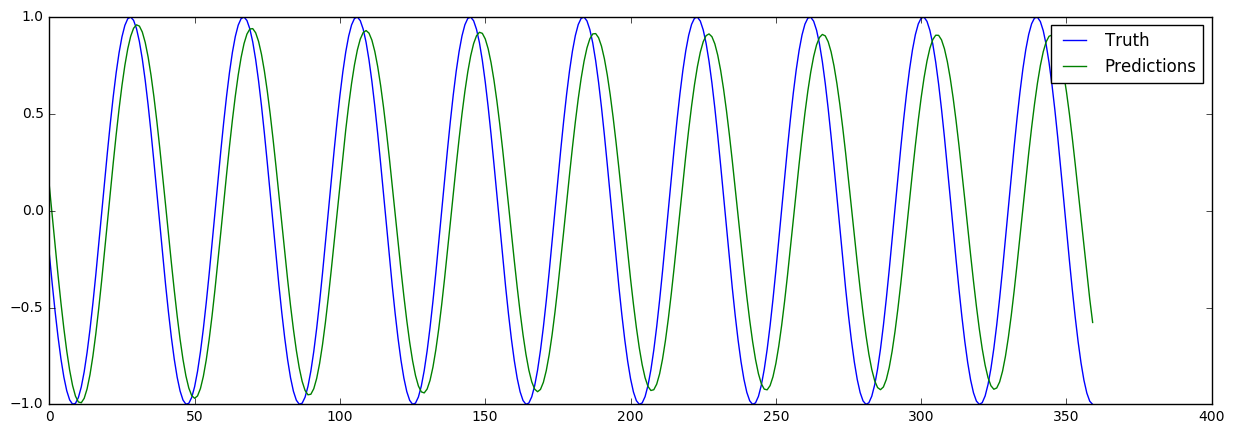

In [27]:
plot_results(predicted, plot_truth)

In [28]:
sum((predicted-plot_truth)**2)/len(predicted)

0.17909684724084377

## Method 3 - LSTM (predict in one go)

In [29]:
def load_data_mult(data, seq_len, pred_forward):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length - pred_forward):
        result.append(data[index: index + sequence_length + pred_forward])
    result = np.array(result)
    x_train = result[:, :-pred_forward-1]
    y_train = result[:, -pred_forward-1:-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return [x_train, y_train]

In [30]:
X_train, y_train = load_data_mult(data, seq_len, PRED_PERIODS)

In [31]:
print(X_train.shape)
print(y_train.shape)

(1041, 100, 1)
(1041, 360)


In [32]:
model = build_model([1, 50, 150, y_train.shape[-1]])

model.fit(
    X_train,
    y_train,
    batch_size=400,
    epochs=3,
    validation_split=0.05)

> Compilation Time :  0.016650676727294922
Train on 988 samples, validate on 53 samples
Epoch 1/3
988/988 [==============================] - 3s - loss: 0.4837 - val_loss: 0.3670
Epoch 2/3
988/988 [==============================] - 2s - loss: 0.3560 - val_loss: 0.2463
Epoch 3/3
988/988 [==============================] - 2s - loss: 0.2192 - val_loss: 0.1357


In [33]:
%%time
X_train_in = X_train[-1]
predicted = model.predict(X_train_in.reshape(1, X_train_in.shape[0], 1))[0] * scaled_by

CPU times: user 205 ms, sys: 50.7 ms, total: 256 ms
Wall time: 178 ms


In [34]:
print(predicted[:10])

[ 0.88282043  0.75995725  0.88826984  0.70957643  0.91575485  0.9106518
  0.57718617  0.32977617  0.4106226   0.32384294]


In [35]:
print(plot_truth[:10])

[-0.22334965 -0.37691066 -0.52069753 -0.65097004 -0.76437455 -0.85794932
 -0.92928553 -0.97652328 -0.99843693 -0.99446219]


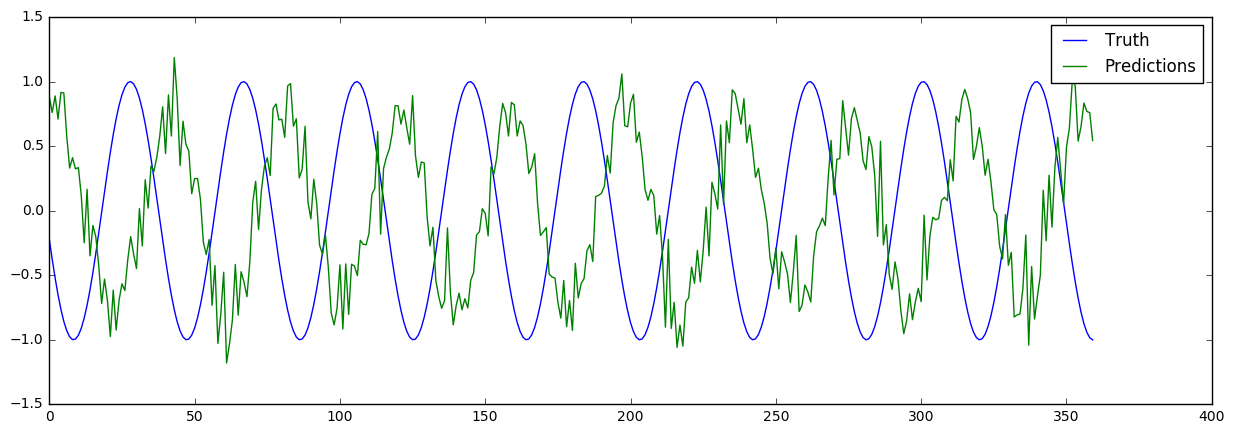

In [36]:
plot_results(predicted, plot_truth)

In [37]:
sum((predicted-plot_truth)**2)/len(predicted)

1.3400498119692807